In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import ast
import warnings
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizer, BertModel

warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

/home/barbara/Documents/HSE/2_year/NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/barbara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/barbara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Анализ датасета

Нами был найден рандомный датасет с [kaggle](https://www.kaggle.com/datasets/vimlendusharma/name-entity-recognition-data), где даже не было указано какие теги исплользуются и что они означают. Поэтому мы начали с выснения этого момента. 

In [2]:
df = pd.read_csv('data/ner.csv')
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [3]:
df['POS'] = df['POS'].apply(ast.literal_eval)
df['Tag'] = df['Tag'].apply(ast.literal_eval)

all_tags = [tag for tags in df['Tag'] for tag in tags]
tag_counts = Counter(all_tags)
tag_df = pd.DataFrame({
    'tag': list(tag_counts.keys()),
    'count': list(tag_counts.values())
}).sort_values('count', ascending=False).reset_index(drop=True)
print(f"Всего уникальных тегов: {len(tag_df)}")
tag_df

Всего уникальных тегов: 17


,tag,count
0,O,887908
1,B-geo,37644
2,B-tim,20333
3,B-org,20143
4,I-per,17251
5,B-per,16990
6,I-org,16784
7,B-gpe,15870
8,I-geo,7414
9,I-tim,6528


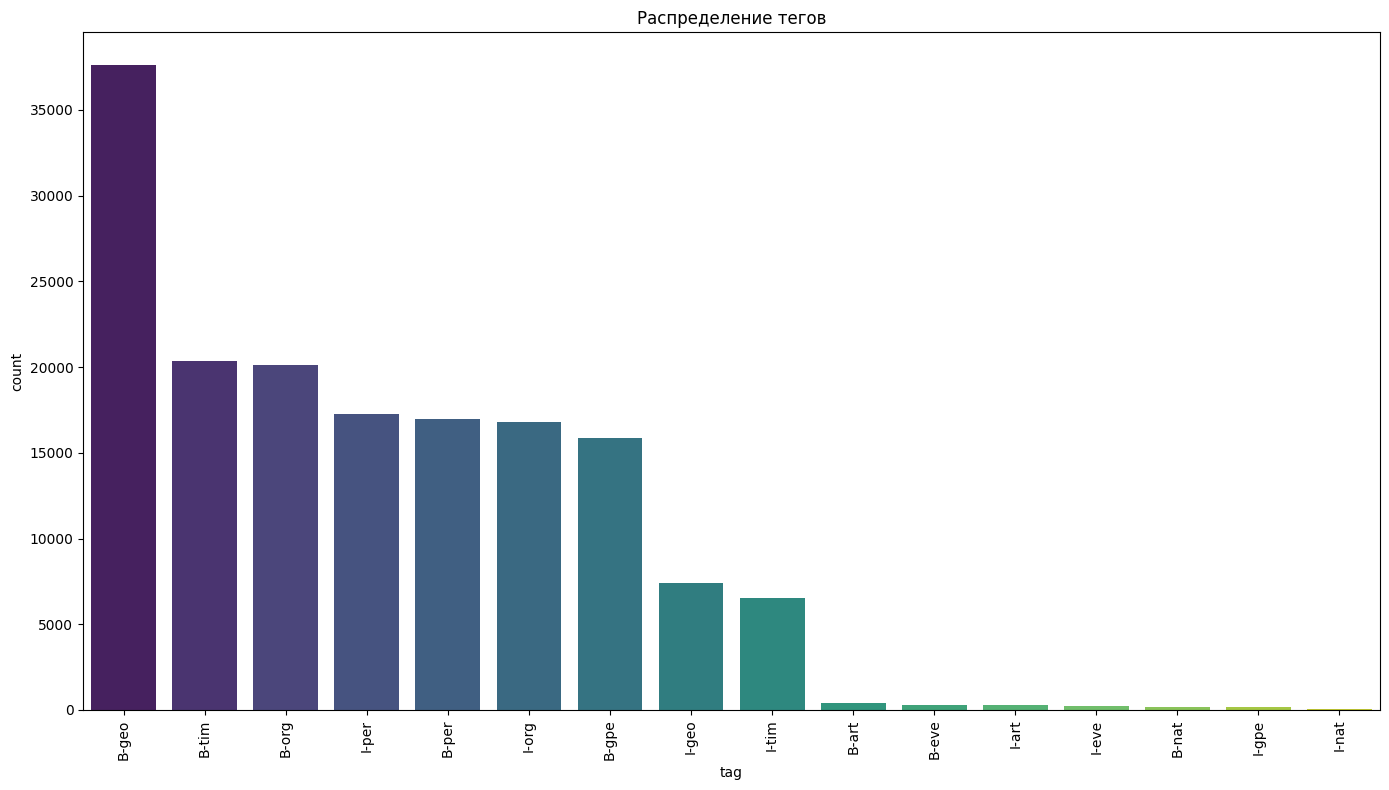

In [4]:
plt.figure(figsize=(14, 8))

sns.barplot(x='tag', y='count', data=tag_df[tag_df.tag != 'O'], palette='viridis')
plt.title('Распределение тегов')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Уже стало понятнее, что и какие теги ознаючт. Per - люди, geo - локация и т.д. Но еще хотелось посмотреть на популярные слова, которые встречаются у тегов, чтобы определить их означение.

In [5]:
entity_tags = [tag for tag in tag_df['tag'] if tag != 'O']

tag_word_counts = {tag: Counter() for tag in entity_tags}
tag_position_stats = {tag: [] for tag in entity_tags}

for _, row in df.iterrows():
    words = row['Sentence'].split(" ")
    tags = row['Tag']

    for i, (word, tag) in enumerate(zip(words, tags)):
        if tag in tag_word_counts:
            tag_word_counts[tag][word.lower()] += 1
            relative_position = i / len(words) if len(words) > 1 else 0.5
            tag_position_stats[tag].append(relative_position)

top_words_data = []
for tag, counter in tag_word_counts.items():
    for word, count in counter.most_common(10):
        top_words_data.append({
            'tag': tag,
            'word': word,
            'count': count
        })

top_words_df = pd.DataFrame(top_words_data)

print("Топ 5 слов для каждого тега:")
for tag in entity_tags:
    top_5 = tag_word_counts[tag].most_common(5)
    print(f"{tag}: {', '.join([f'{word} ({count})' for word, count in top_5])}")

Топ 5 слов для каждого тега:
B-geo: u.s. (3169), iraq (1666), united (1259), iran (1243), china (908)
B-tim: tuesday (1363), thursday (1286), friday (1237), monday (1228), wednesday (1224)
B-org: u.s. (847), united (728), u.n. (547), taleban (542), nato (471)
I-per: bush (820), minister (470), chavez (349), abbas (234), obama (168)
B-per: mr. (3085), president (2436), prime (859), minister (202), ms. (176)
I-org: nations (596), of (491), and (475), union (440), council (364)
B-gpe: iraqi (1137), palestinian (989), israeli (987), afghan (814), british (568)
I-geo: states (1256), korea (477), strip (196), york (185), of (184)
I-tim: of (381), and (199), - (184), , (174), 2003 (154)
B-art: english (13), facebook (10), twitter (9), nobel (7), gdp (7)
B-eve: ii (70), world (43), australian (13), i (10), olympic (9)
I-art: of (7), a (6), de (5), space (5), station (5)
I-eve: war (38), open (19), i (17), cup (16), day (15)
B-nat: katrina (47), h5n1 (33), hurricane (20), marburg (19), aids (15

Итого получается следующий список тегов:

**geo** - Geographical Entity 

**tim** - Time Indicator

**org** - Organization

**per** - Person

**gpe** - Geopolitical Entity

**art** - Artifact

**eve** - Event

**nat** - Natural Phenomen

Смотря на результаты распределений мы решили действовать следующим образом. Во-первых, такие теги как nat, art, eve имеют маленькую репрезентацию в датасете. Это приведет к тому, что во время обучения скорее всего эти теги будут самыми проблематичными для распознования. 
Один из обходов это сделать следующим образом:
1. Попросить какую-то ллмку сгенерировать массив разных событий, феноменов и т.д.
2. Для каждого итема в массиве сгенерировать несколько предложений. 

Но мы таким заниматься не будем. Мы решили рассмотреть задачу с другой стороны. У нас есть такие метки, как geo и gpe, географическая и геополитическая сущности. Зачастую имена в таких тегах похожи, что должно добавить сложности в обучении с точки зрения того, что классы будут путаться. И нам показалось, что будет интересно сосредоточиться на этом.   

Поэтому посмотрим на совпадение слов в этих тегах.

In [6]:
geo_gpe_tags = ['B-gpe', 'I-gpe', 'B-geo', 'I-geo']

all_words = set()
for tag in geo_gpe_tags:
    all_words.update(tag_word_counts[tag].keys())

overlap_df = pd.DataFrame(index=list(all_words), columns=geo_gpe_tags)
for tag in geo_gpe_tags:
    for word in all_words:
        overlap_df.loc[word, tag] = tag_word_counts[tag].get(word, 0)

overlap_df['total_count'] = overlap_df.sum(axis=1)
overlap_df = overlap_df.reset_index().rename(columns={'index': 'word'})
overlap_df['present_in_tags'] = overlap_df.apply(
    lambda row: ', '.join([tag for tag in geo_gpe_tags if row[tag] > 0]), 
    axis=1
)
overlap_df['number_of_tags'] = overlap_df['present_in_tags'].apply(lambda x: len(x.split(', ')))

overlap_df = overlap_df.sort_values(
    ['number_of_tags', 'total_count'], 
    ascending=[False, False]
).reset_index(drop=True)

print("Кол-во уникальных слов появляющих в geo/gpe тегах:")
for i in range(1, len(geo_gpe_tags) + 1):
    count = len(overlap_df[overlap_df['number_of_tags'] == i])
    print(f"В {i} тегах: {count}")
print("Кол-во слов всего:", len(all_words))

overlap_df.head(20)

Кол-во уникальных слов появляющих в geo/gpe тегах:
В 1 тегах: 3434
В 2 тегах: 440
В 3 тегах: 86
В 4 тегах: 7
Кол-во слов всего: 3967


,word,B-gpe,I-gpe,B-geo,I-geo,total_count,present_in_tags,number_of_tags
0,korea,5,11,19,477,512,"B-gpe, I-gpe, B-geo, I-geo",4
1,african,254,4,83,17,358,"B-gpe, I-gpe, B-geo, I-geo",4
2,arab,122,2,8,20,152,"B-gpe, I-gpe, B-geo, I-geo",4
3,congo,1,1,80,55,137,"B-gpe, I-gpe, B-geo, I-geo",4
4,yemen,3,1,23,4,31,"B-gpe, I-gpe, B-geo, I-geo",4
5,mongolia,3,1,5,3,12,"B-gpe, I-gpe, B-geo, I-geo",4
6,lankan,1,3,1,3,8,"B-gpe, I-gpe, B-geo, I-geo",4
7,u.s.,95,0,3169,6,3270,"B-gpe, B-geo, I-geo",3
8,iraq,6,0,1666,59,1731,"B-gpe, B-geo, I-geo",3
9,iran,27,0,1243,7,1277,"B-gpe, B-geo, I-geo",3


Еще интересность этих тегов состоит в том, что если использовать лемматизацию - приведение в первоначальную форму, то скорее всего совпадений слов будет еще больше. 

Поэтому на самом деле интереснее посмотреть на позицию слов в предложении в зависимости от тега и на POS (к какой части речи принадлежат слова).

#### Позиция в предложении

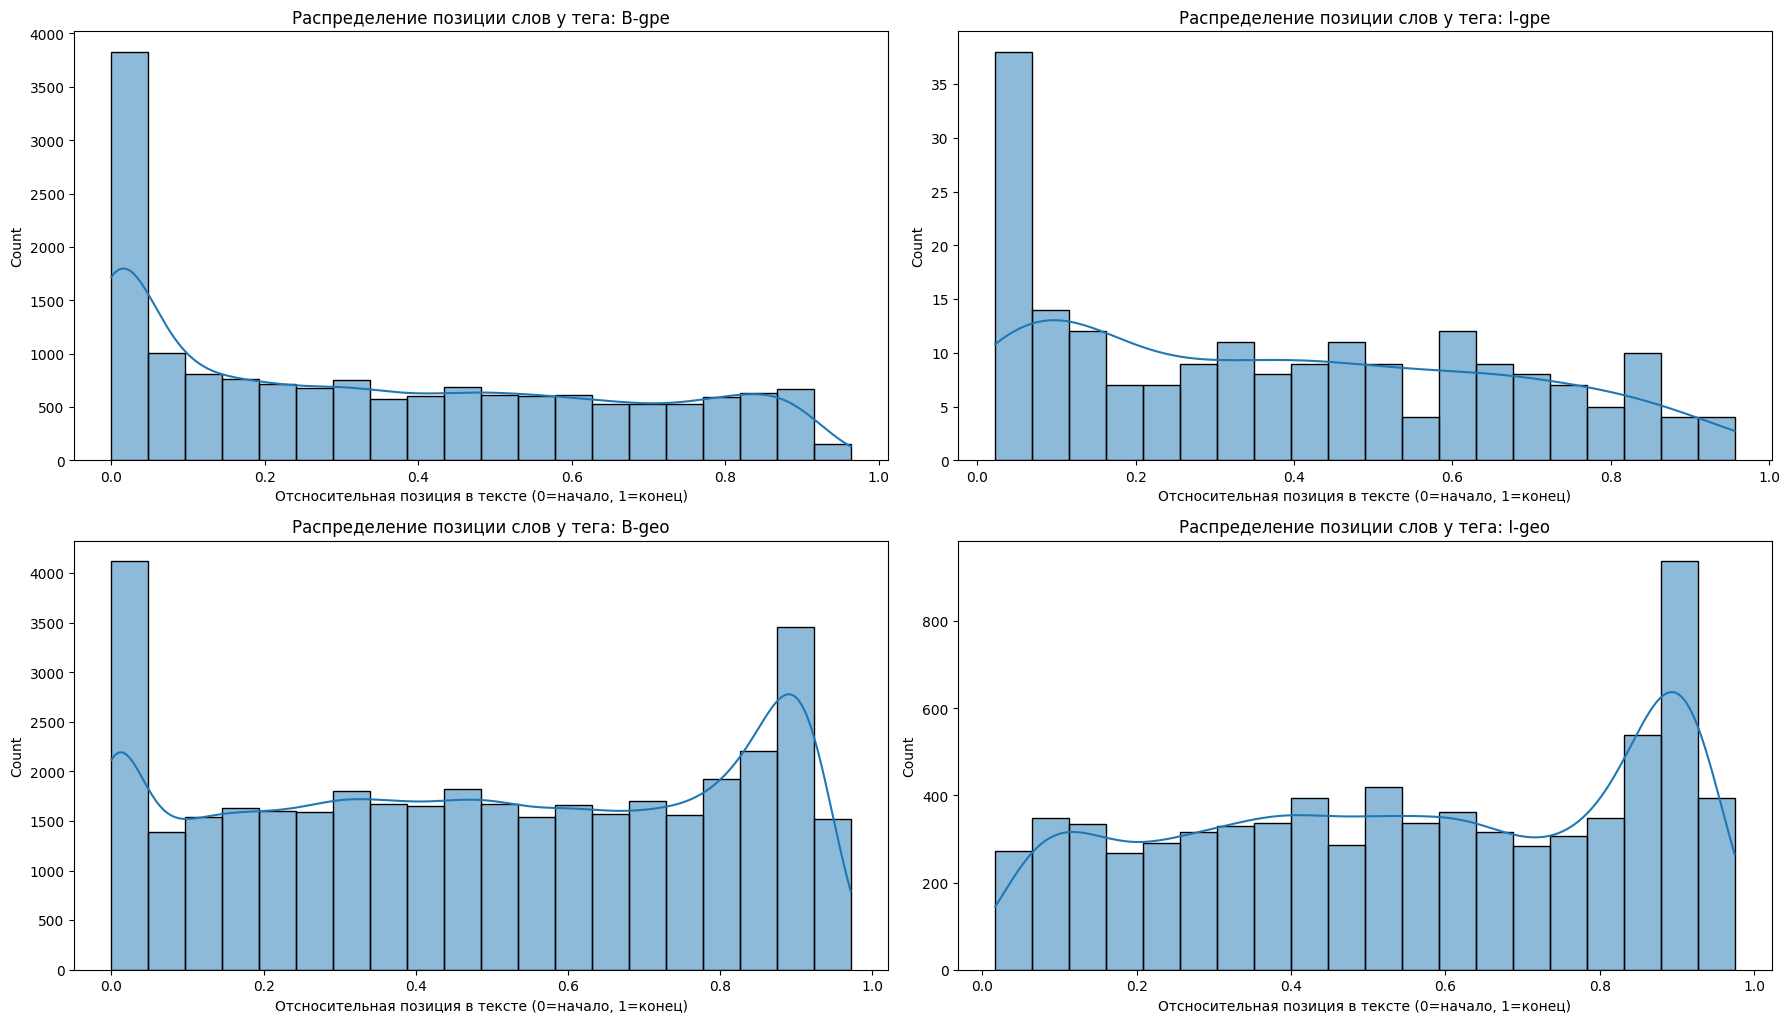

In [7]:
plt.figure(figsize=(18, 15))
for i, tag in enumerate(geo_gpe_tags):
    plt.subplot(3, 2, i+1)
    
    if tag_position_stats[tag]:
        sns.histplot(tag_position_stats[tag], bins=20, kde=True)
        plt.title(f'Распределение позиции слов у тега: {tag}')
        plt.xlabel('Отсносительная позиция в тексте (0=начало, 1=конец)')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()

Можно заметить, что геополитические слова используются скорее в начале, а вот географические объекты в начале и конце. Если подавать этот признак в модель, то возможно результаты улучшаться.

#### Исследование частей речи

In [8]:
all_pos = [pos for pos_list in df['POS'] for pos in pos_list]
pos_counts = Counter(all_pos)
pos_df = pd.DataFrame({
    'pos': list(pos_counts.keys()),
    'count': list(pos_counts.values())
}).sort_values('count', ascending=False).reset_index(drop=True)

print(f"Уникальные POS теги: {len(pos_df)}")
pos_df.head(10)

Уникальные POS теги: 42


,pos,count
0,NN,145807
1,NNP,131426
2,IN,120996
3,DT,98454
4,JJ,78412
5,NNS,75840
6,.,47831
7,VBD,39379
8,",",32757
9,VBN,32328


Вот [здесь](https://www.guru99.com/pos-tagging-chunking-nltk.html) есть описание тегов.


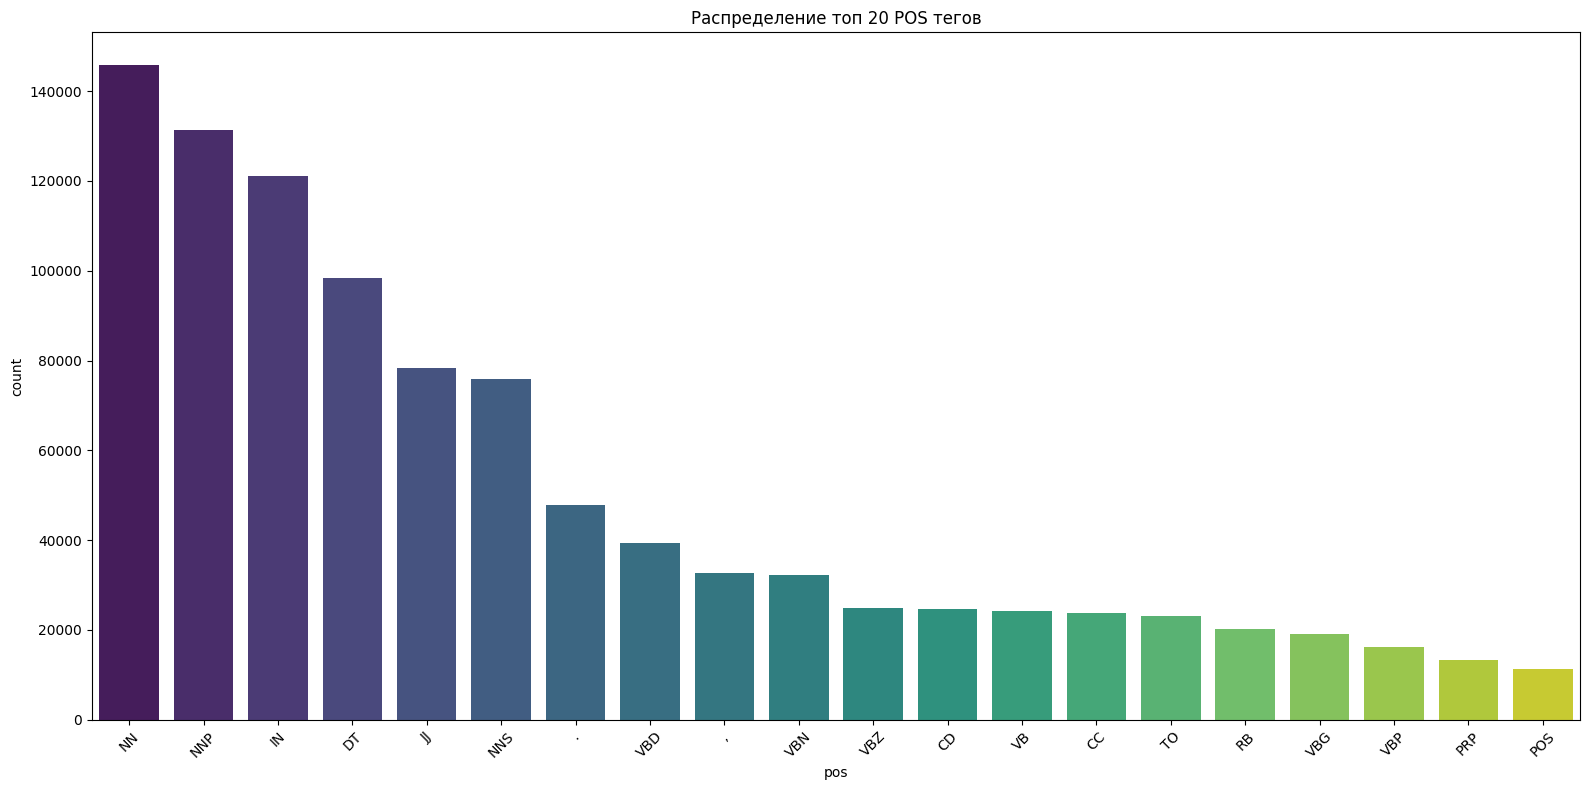

In [9]:
plt.figure(figsize=(16, 8))
top_pos = pos_df.head(20)
sns.barplot(x='pos', y='count', data=top_pos, palette='viridis')
plt.title('Распределение топ 20 POS тегов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
geo_gpe_tags = ['B-gpe', 'I-gpe', 'B-geo', 'I-geo']
pos_ner_pairs = []

for _, row in df.iterrows():
    pos_tags = row['POS']
    ner_tags = row['Tag']

    for pos, ner in zip(pos_tags, ner_tags):
        if ner in geo_gpe_tags:
            pos_ner_pairs.append((pos, ner))

pos_ner_counts = Counter(pos_ner_pairs)
pos_ner_df = pd.DataFrame([
    {'pos': pos, 'ner': ner, 'count': count} 
    for (pos, ner), count in pos_ner_counts.items()
])

In [11]:
pos_ner_pivot = pos_ner_df.pivot_table(
    index='ner', 
    columns='pos', 
    values='count', 
    aggfunc='sum',
    fill_value=0
)

ner_most_common_pos = {}
for ner_tag in pos_ner_pivot.index:
    pos_freq = pos_ner_pivot.loc[ner_tag].sort_values(ascending=False)
    top_pos = pos_freq.head(5)
    ner_most_common_pos[ner_tag] = [(pos, count) for pos, count in top_pos.items()]

print("Наиболее популярные POS теги:")
for ner_tag, pos_list in ner_most_common_pos.items():
    pos_str = ', '.join([f"{pos} ({count})" for pos, count in pos_list])
    print(f"{ner_tag}: {pos_str}")
pos_ner_pivot

Наиболее популярные POS теги:
B-geo: NNP (36458), JJ (712), DT (205), NN (100), NNPS (42)
B-gpe: JJ (12999), NNS (1403), NNP (1343), NN (123), NNPS (2)
I-geo: NNP (5743), NNPS (1307), IN (198), NN (83), : (24)
I-gpe: JJ (86), NNP (58), NNS (34), NNPS (12), NN (5)


pos,:,;,CC,CD,DT,IN,JJ,JJS,NN,NNP,NNPS,NNS,RB,VB,VBP,VBZ,``
ner,,,,,,,,,,,,,,,,,
B-geo,1,0,0,34,205,33,712,1,100,36458,42,28,3,25,1,0,1
B-gpe,0,0,0,0,0,0,12999,0,123,1343,2,1403,0,0,0,0,0
I-geo,24,5,1,5,5,198,22,0,83,5743,1307,10,0,0,0,2,9
I-gpe,0,0,0,0,0,3,86,0,5,58,12,34,0,0,0,0,0


С сайта, который мы указывали выше, выходит, что:

NNP - proper noun, singular 

JJ - an adjective

DT - determiner

NN - noun, singular

NNPS - proper noun, plural

NNS - noun, plural

IN - preposition

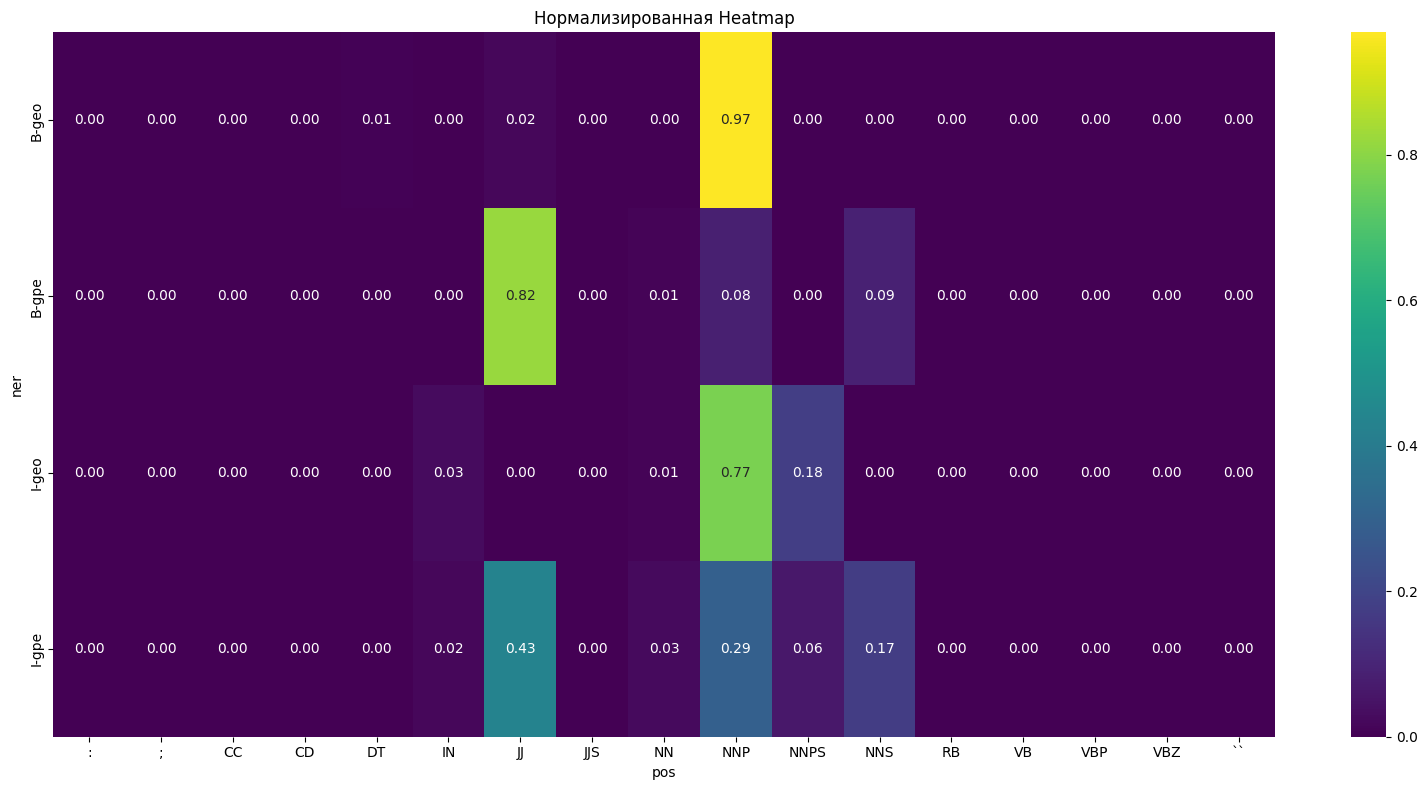

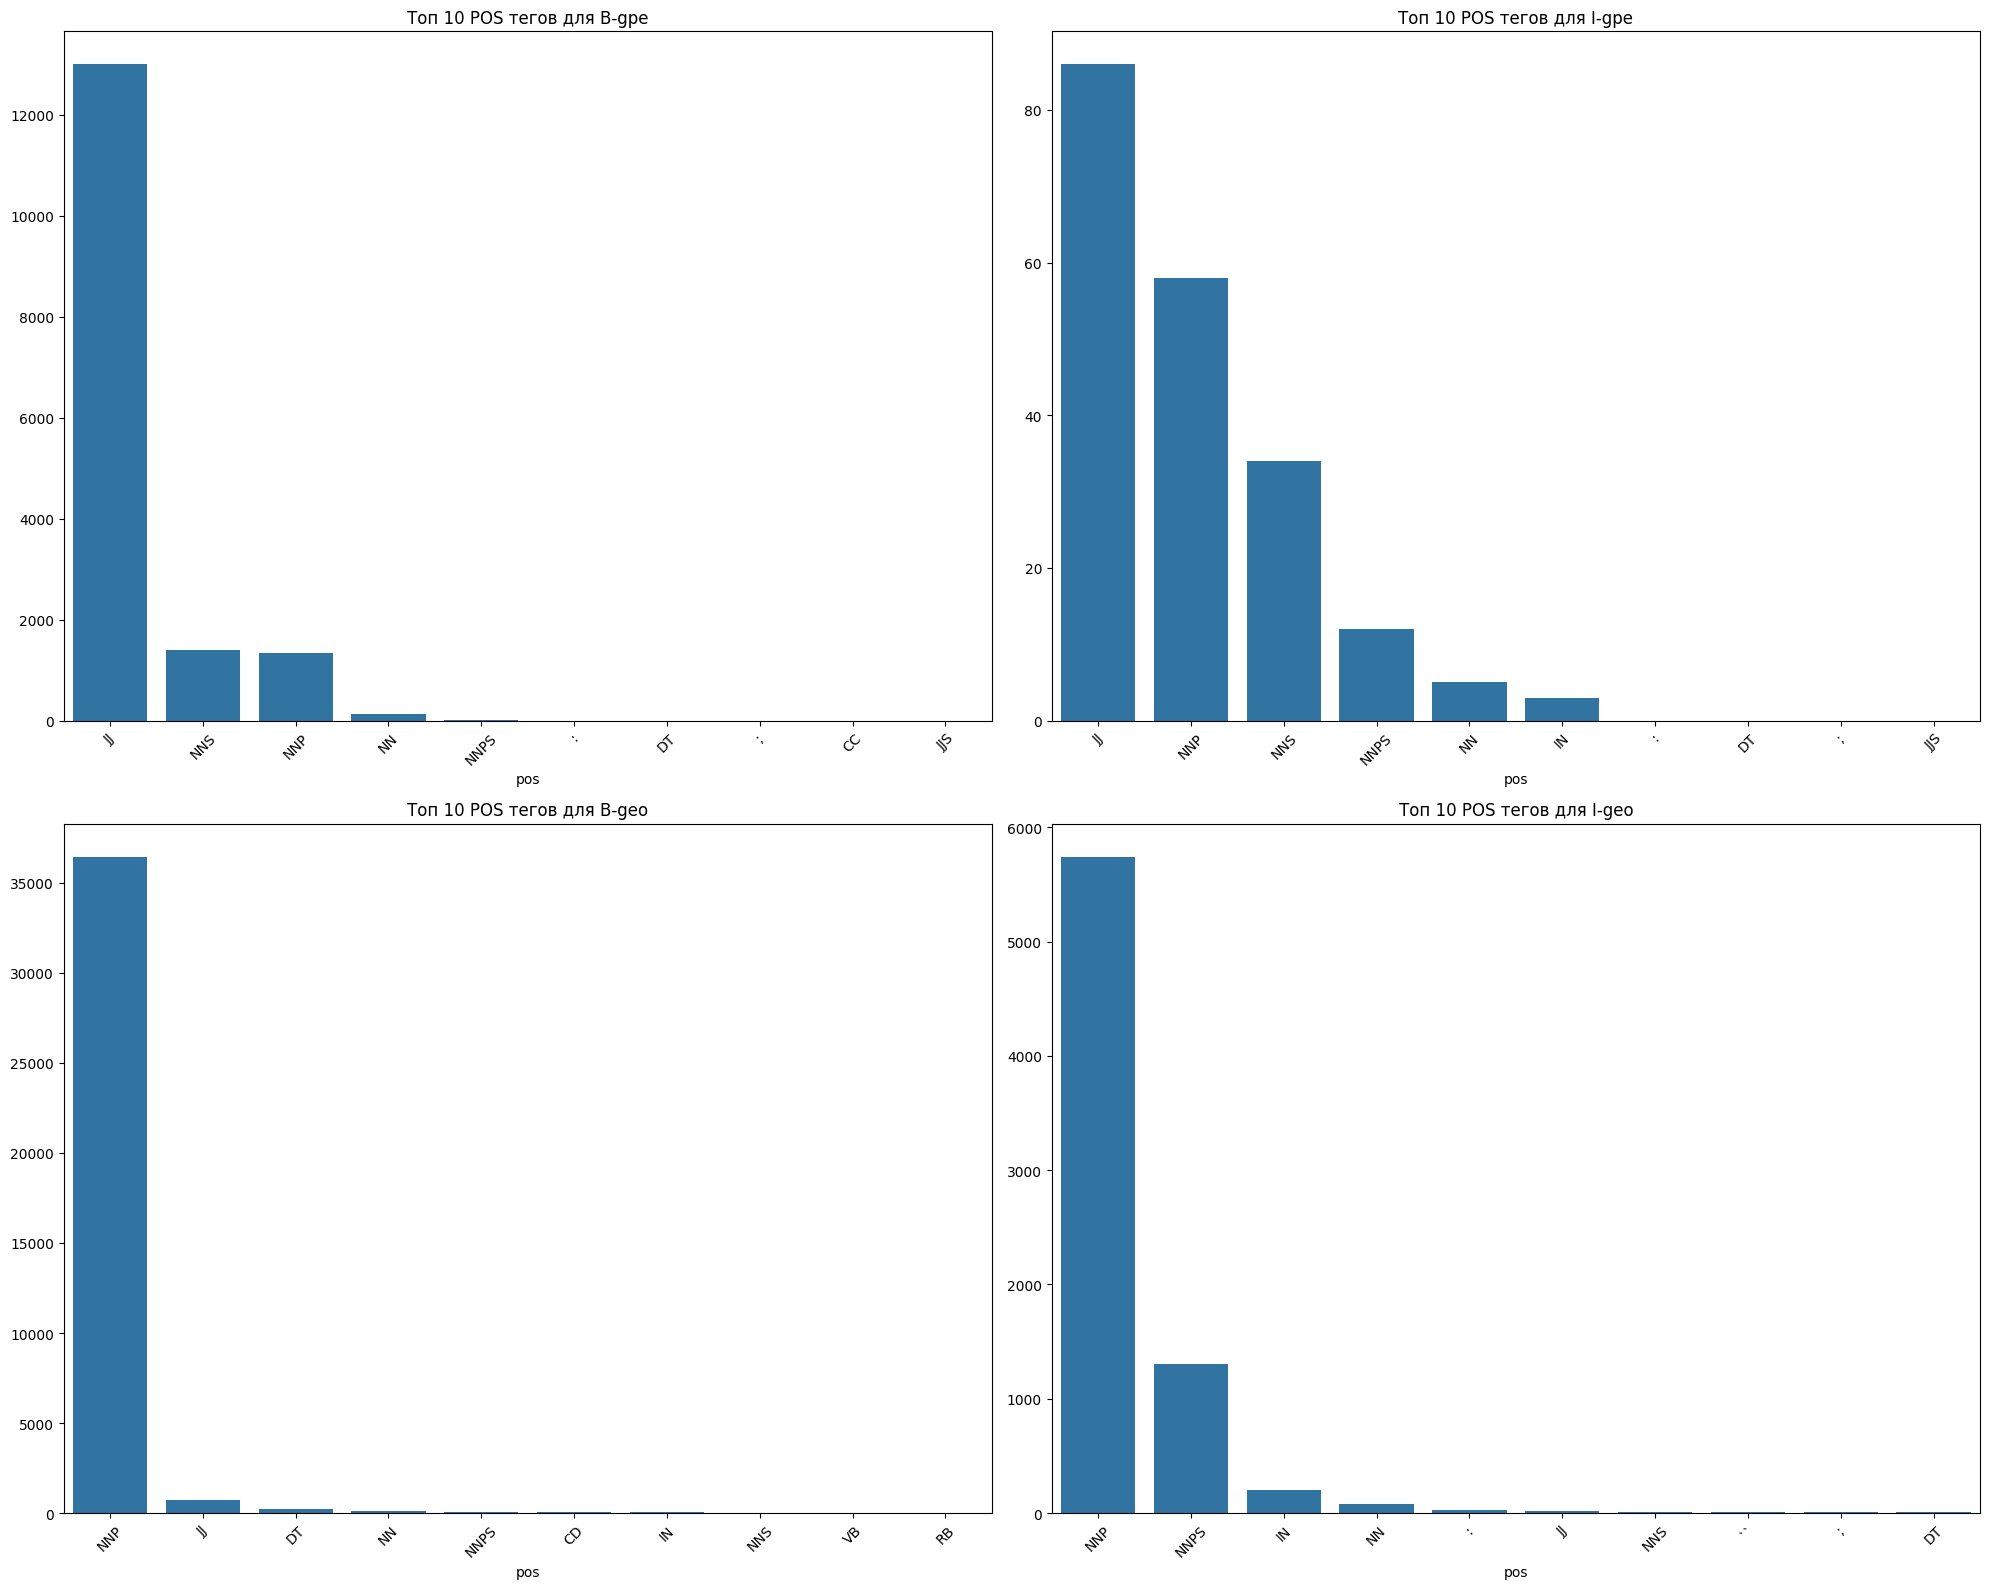

In [12]:
norm_pivot = pos_ner_pivot.div(pos_ner_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(16, 8))
sns.heatmap(norm_pivot, cmap='viridis', annot=True, fmt='.2f')
plt.title('Нормализированная Heatmap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 16))
for i, tag in enumerate(geo_gpe_tags):
    plt.subplot(2, 2, i+1)
    
    if tag in pos_ner_pivot.index:
        top_pos = pos_ner_pivot.loc[tag].sort_values(ascending=False).head(10)
        sns.barplot(x=top_pos.index, y=top_pos.values)
        plt.title(f'Топ 10 POS тегов для {tag}')
        plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

В целом получается логично, что геопозиция в большинстве случаев это существительное, а вот геополитическое слово скорее всего это прилагательное.

In [13]:
unique_pos_counts = {}
for ner_tag in pos_ner_pivot.index:
    pos_dist = pos_ner_pivot.loc[ner_tag]
    unique_pos_counts[ner_tag] = (pos_dist > 0).sum()

unique_df = pd.DataFrame({
    'tag': list(unique_pos_counts.keys()),
    'unique_pos_tags': list(unique_pos_counts.values())
}).sort_values('unique_pos_tags', ascending=False)

unique_df

,tag,unique_pos_tags
0,B-geo,14
2,I-geo,13
3,I-gpe,6
1,B-gpe,5


Посмотрим энтропию, чтобы оценить насколько разнообразен POS у каждого тега.

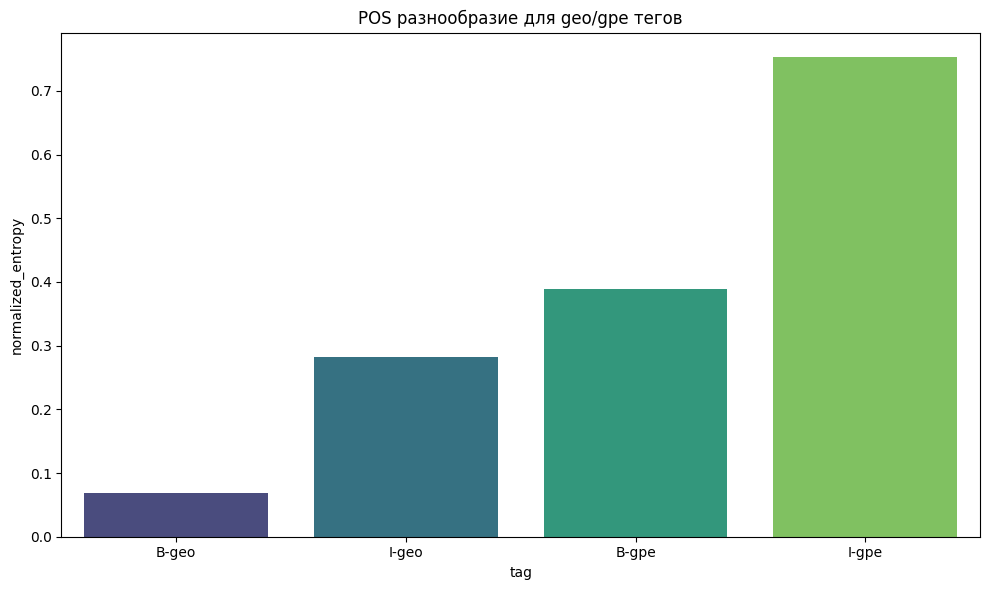

In [14]:
from scipy.stats import entropy

geo_gpe_pos_entropy = {}
for ner_tag in pos_ner_pivot.index:
    pos_dist = pos_ner_pivot.loc[ner_tag]
    pos_dist = pos_dist[pos_dist > 0]
    probs = pos_dist / pos_dist.sum()
    geo_gpe_pos_entropy[ner_tag] = entropy(probs, base=len(probs))

entropy_df = pd.DataFrame({
    'tag': list(geo_gpe_pos_entropy.keys()),
    'normalized_entropy': list(geo_gpe_pos_entropy.values())
}).sort_values('normalized_entropy')

plt.figure(figsize=(10, 6))
sns.barplot(x='tag', y='normalized_entropy', data=entropy_df, palette='viridis')
plt.title('POS разнообразие для geo/gpe тегов')
plt.tight_layout()
plt.show()


Более низкая энтропия у B-geo тега означает, что хоть он и имеет больше всех уникальных POS тегов, но он распределяюется среди них не одинаково. А точнее он больше других склонен выбирать только парочку конкретных POS тегов.

Так что такая вещь как POS, тоже может помочь лучше различать эти два класса.

### Определение сущностей в тексте

Идея следующая. Мы берем натренированный токенайзер, чтобы сделать эмбеддинги для слов (т.к. если мы сейчас будем делать какой-нибудь словарь, то там будут только слова, которые были в этом датасете, а мы предполагаемо хотим вообще заинференсить для любого текста), берем POS, считаем позицию в предложении и данные фичи засовываем в какую-нибудь простую нейронную сетку (не lstm, не cnn и не трансформерный энкодер).

In [15]:
df = pd.read_csv('data/ner.csv')
df['POS'] = df['POS'].apply(ast.literal_eval)
df['Tag'] = df['Tag'].apply(ast.literal_eval)

words = []
pos_tags = []
rel_positions = []
ner_tags = []

for _, row in df.iterrows():
    sentence_words = row['Sentence'].split(" ")
    sentence_pos = row['POS']
    sentence_tags = row['Tag']

    sentence_len = len(sentence_words)
    sentence_rel_positions = [i / sentence_len for i in range(sentence_len)]

    words.extend(sentence_words)
    pos_tags.extend(sentence_pos)
    rel_positions.extend(sentence_rel_positions)
    ner_tags.extend(sentence_tags)

data = pd.DataFrame({
    'word': words,
    'pos': pos_tags,
    'rel_position': rel_positions,
    'tag': ner_tags
})

data.head()

,word,pos,rel_position,tag
0,Thousands,NNS,0.000000,O
1,of,IN,0.041667,O
2,demonstrators,NNS,0.083333,O
3,have,VBP,0.125000,O
4,marched,VBN,0.166667,O


In [16]:
geo_gpe_tags = ['B-geo', 'I-geo', 'B-gpe', 'I-gpe', 'O']
filtered_data = data[data['tag'].isin(geo_gpe_tags)]
filtered_data['tag'].value_counts()

tag
O        887908
B-geo     37644
B-gpe     15870
I-geo      7414
I-gpe       198
Name: count, dtype: int64

Только еще момент, что из-за того, что мы переписали большинство теги в O, то у нас получился очень инбалансный датасет, поэтому нам нужно задаунсэмплить O тег.

In [17]:
o_samples = filtered_data[filtered_data['tag'] == 'O']
geo_gpe_samples = filtered_data[filtered_data['tag'] != 'O']

n_geo_gpe = len(geo_gpe_samples)
n_o_to_keep = min(len(o_samples), n_geo_gpe * 3)
o_downsampled = o_samples.sample(n_o_to_keep, random_state=42)
balanced_data = pd.concat([geo_gpe_samples, o_downsampled])

balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_data['tag'].value_counts()

tag
O        183378
B-geo     37644
B-gpe     15870
I-geo      7414
I-gpe       198
Name: count, dtype: int64

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

unique_words = balanced_data['word'].unique()
word_to_idx = {word: idx for idx, word in enumerate(unique_words)}
word_to_idx['<UNK>'] = len(word_to_idx)
vocab_size = len(word_to_idx)

pos_encoder = LabelEncoder()
balanced_data['pos_encoded'] = pos_encoder.fit_transform(balanced_data['pos'])
num_pos_tags = len(pos_encoder.classes_)

label_encoder = LabelEncoder()
balanced_data['tag_encoded'] = label_encoder.fit_transform(balanced_data['tag'])

In [19]:
word_indices = [word_to_idx.get(word.lower(), word_to_idx['<UNK>']) for word in balanced_data['word']]

X_word = np.array(word_indices)
X_pos = balanced_data['pos_encoded'].values
X_rel_pos = balanced_data['rel_position'].values
y = balanced_data['tag_encoded'].values

X_word_train, X_word_test, X_pos_train, X_pos_test, X_rel_pos_train, X_rel_pos_test, y_train, y_test = train_test_split(
    X_word, X_pos, X_rel_pos, y, test_size=0.2, random_state=42
)

X_word_train_tensor = torch.LongTensor(X_word_train)
X_word_test_tensor = torch.LongTensor(X_word_test)
X_pos_train_tensor = torch.LongTensor(X_pos_train)
X_pos_test_tensor = torch.LongTensor(X_pos_test)
X_rel_pos_train_tensor = torch.FloatTensor(X_rel_pos_train).unsqueeze(1)
X_rel_pos_test_tensor = torch.FloatTensor(X_rel_pos_test).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_word_train_tensor, X_pos_train_tensor, X_rel_pos_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_word_test_tensor, X_pos_test_tensor, X_rel_pos_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training samples: {len(X_word_train)}")
print(f"Test samples: {len(X_word_test)}")
print(f"Batch size: {batch_size}")


Training samples: 195603
Test samples: 48901
Batch size: 128


In [20]:
class NERModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_pos_tags: int,
        num_classes: int, 
        token_embed_dim: int = 128, 
        pos_embed_dim: int = 32, 
        hidden_dim1: int = 256, 
        hidden_dim2: int = 128, 
        dropout1: float = 0.3, 
        dropout2: float = 0.2
    ):
        super(NERModel, self).__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, token_embed_dim)
        self.pos_embedding = nn.Embedding(num_pos_tags, pos_embed_dim)
        self.rel_pos_projection = nn.Linear(1, 16)
        
        total_input_dim = token_embed_dim + pos_embed_dim + 16
        self.fc1 = nn.Linear(total_input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout1)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)

        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        
    def forward(self, word_indices, pos_indices, rel_positions):
        token_embed = self.token_embedding(word_indices)
        pos_embed = self.pos_embedding(pos_indices)
        rel_pos_embed = self.rel_pos_projection(rel_positions)
    
        x = torch.cat([token_embed, pos_embed, rel_pos_embed], dim=1)
    
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        
        return x

num_classes = len(label_encoder.classes_)
model = NERModel(
    vocab_size=vocab_size,
    num_pos_tags=num_pos_tags,
    num_classes=num_classes,
    token_embed_dim=128,
    pos_embed_dim=32,
    hidden_dim1=256,
    hidden_dim2=128,
    dropout1=0.3,
    dropout2=0.2
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)
print(f"Всего параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


NERModel(
  (token_embedding): Embedding(15946, 128)
  (pos_embedding): Embedding(41, 32)
  (rel_pos_projection): Linear(in_features=1, out_features=16, bias=True)
  (fc1): Linear(in_features=176, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)
Всего параметров: 2,122,053


In [21]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 10
):
    train_losses = []
    train_accuracies = []
    
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for word_ids, pos_ids, rel_pos, targets in train_loader:
            optimizer.zero_grad()

            outputs = model(word_ids, pos_ids, rel_pos)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * word_ids.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return train_losses, train_accuracies

In [22]:
checkpoint_path = 'model/ner_checkpoint.pt'

if os.path.exists(checkpoint_path):
    print(f"Есть сохраненная модель '{checkpoint_path}'. Загружаем...")
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    train_accuracies = checkpoint['train_accuracies']
    num_epochs = checkpoint['num_epochs']
    
    print(f"Модель загружена успешно!")
    print(f"Ранее обучалась на {num_epochs} эпохах")
    print(f"Точность на последней эпохе: {train_accuracies[-1]:.4f}")
    print(f"Потери на последней эпохе: {train_losses[-1]:.4f}")
    
else:
    print("Нет сохраненной модели. Начинаем обучение с нуля...")

    num_epochs = 20
    print("Модель обучается...")
    train_losses, train_accuracies = train_enhanced_model(model, train_loader, criterion, optimizer, num_epochs)
    
    print(f"\nСохраняем модель в '{checkpoint_path}'...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'num_epochs': num_epochs,
        'vocab_size': vocab_size,
        'num_pos_tags': num_pos_tags,
        'num_classes': num_classes
    }, checkpoint_path)
    
    print("Модель сохранена")

Есть сохраненная модель 'model/ner_checkpoint.pt'. Загружаем...
Модель загружена успешно!
Ранее обучалась на 20 эпохах
Точность на последней эпохе: 0.9652
Потери на последней эпохе: 0.1262


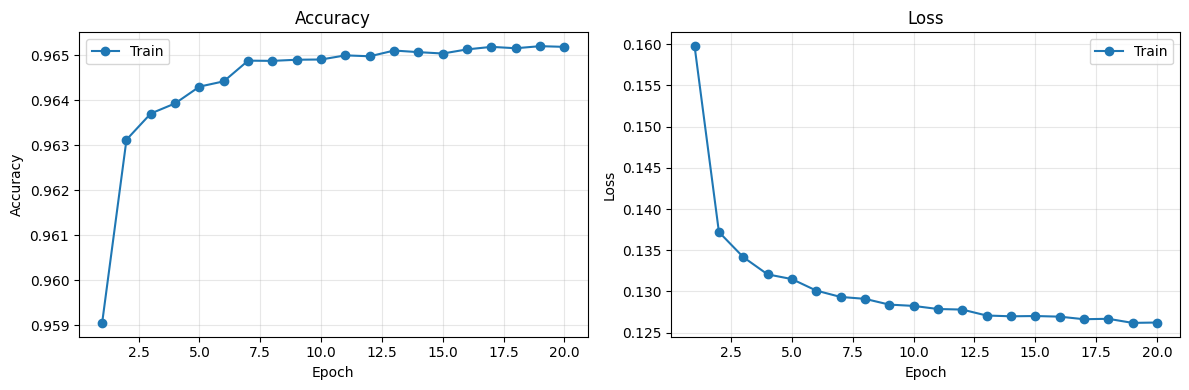

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
def evaluate_model(model: nn.Module, test_loader: torch.utils.data.DataLoader, criterion: nn.Module):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for word_ids, pos_ids, rel_pos, targets in test_loader:
            outputs = model(word_ids, pos_ids, rel_pos)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * word_ids.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss = test_loss / total
    test_accuracy = correct / total
    
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1345
Test Accuracy: 0.9638


In [25]:
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for word_ids, pos_ids, rel_pos, targets in test_loader:
        outputs = model(word_ids, pos_ids, rel_pos)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

y_pred = np.array(all_predictions)
y_true = np.array(all_targets)

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

print(classification_report(y_true_labels, y_pred_labels))


              precision    recall  f1-score   support

       B-geo       0.85      0.98      0.91      7680
       B-gpe       0.94      0.91      0.92      3183
       I-geo       0.87      0.38      0.53      1474
       I-gpe       0.00      0.00      0.00        36
           O       0.99      0.99      0.99     36528

    accuracy                           0.96     48901
   macro avg       0.73      0.65      0.67     48901
weighted avg       0.96      0.96      0.96     48901



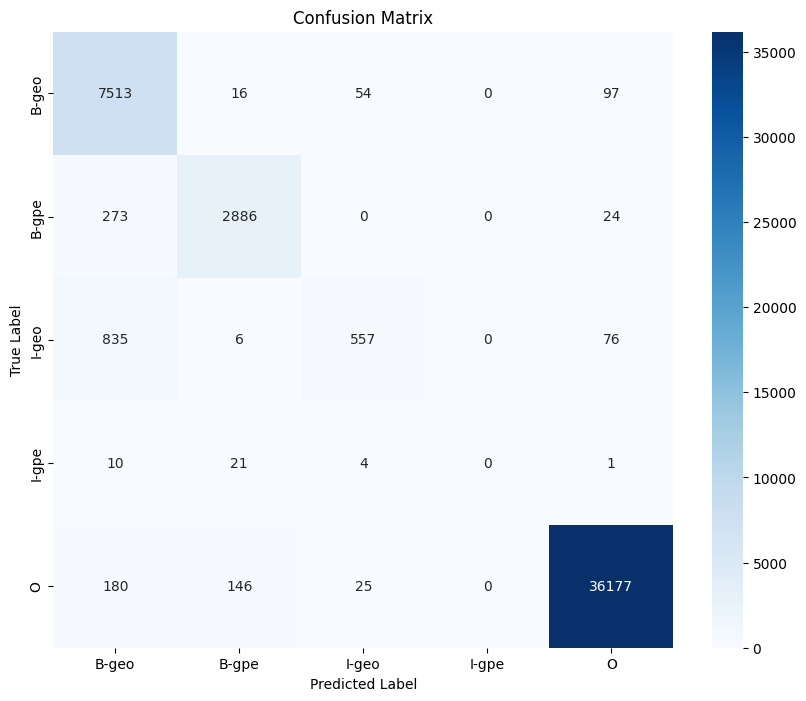


Per-class accuracy:
B-geo: 0.9783 (7513/7680)
B-gpe: 0.9067 (2886/3183)
I-geo: 0.3779 (557/1474)
I-gpe: 0.0000 (0/36)
O: 0.9904 (36177/36528)


In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nPer-class accuracy:")
for i, class_name in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")


Можно увидеть, что I-gpe совсем плох. А точнее ужасен, т.к. ни разу не был предсказан. Скорее всего это из-за того, что кол-во примеров с ним было меньше, чем с другими. Т.к. слова категории gpe состояли чаще из одного слова, чем из нескольких.

gpe и gep все еще иногда путаются, но в итоге предсказываются неплохо.

### Инференс на своих предложениях

Для того, чтобы для наших предложений получить POS, мы воспользовались библиотекой NLTK.

In [27]:
def predict_tags_enhanced(
    model: nn.Module,
    text: str,
    word_to_idx: dict,
    pos_encoder: LabelEncoder,
    label_encoder: LabelEncoder
    ):

    tokens = word_tokenize(text, language='english', preserve_line=True)
    pos_tags = [tag for _, tag in pos_tag(tokens)]
    sentence_len = len(tokens)
    rel_positions = [i / sentence_len for i in range(sentence_len)]
    word_indices = [word_to_idx.get(word.lower(), word_to_idx['<UNK>']) for word in tokens]

    pos_indices = []
    for pos in pos_tags:
        try:
            pos_idx = np.where(pos_encoder.classes_ == pos)[0]
            if len(pos_idx) > 0:
                pos_indices.append(pos_idx[0])
            else:
                pos_indices.append(0)
        except:
            pos_indices.append(0)

    word_tensor = torch.LongTensor(word_indices)
    pos_tensor = torch.LongTensor(pos_indices)
    rel_pos_tensor = torch.FloatTensor(rel_positions).unsqueeze(1)

    model.eval()

    with torch.no_grad():
        outputs = model(word_tensor, pos_tensor, rel_pos_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_labels = label_encoder.inverse_transform(predicted.numpy())

    results = pd.DataFrame({
        'Word': tokens,
        'POS': pos_tags,
        'Position': [f"{p:.3f}" for p in rel_positions],
        'Predicted_Tag': predicted_labels
    })
    
    return results

test_sentences = [
    "I live in New York City.",
    "What's up, russian?",
    "I'm going to the store to buy some gun.",
]

for i, sentence in enumerate(test_sentences, 1):
    print(f"\n{i}. Input: {sentence}")
    print("-" * 80)
    results = predict_tags_enhanced(model, sentence, word_to_idx, pos_encoder, label_encoder)
    print(results.to_string(index=False))
    print()



1. Input: I live in New York City.
--------------------------------------------------------------------------------
Word POS Position Predicted_Tag
   I PRP    0.000             O
live VBP    0.143             O
  in  IN    0.286             O
 New NNP    0.429         B-geo
York NNP    0.571         B-geo
City NNP    0.714         I-geo
   .   .    0.857             O


2. Input: What's up, russian?
--------------------------------------------------------------------------------
   Word POS Position Predicted_Tag
   What  WP    0.000             O
     's VBZ    0.167             O
     up  RP    0.333             O
      ,   ,    0.500             O
russian  JJ    0.667         B-gpe
      ?   .    0.833             O


3. Input: I'm going to the store to buy some gun.
--------------------------------------------------------------------------------
 Word POS Position Predicted_Tag
    I PRP    0.000             O
   'm VBP    0.091             O
going VBG    0.182             O
   t